## Import relevant libraries

In [1]:
import pandas as pd
import numpy as np
import datetime as datetime

## Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

## Clustering
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids

## Evaluation
from sklearn import metrics

## Scaling
from sklearn.preprocessing import MinMaxScaler

# Timeseries 
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

## Train Test Split
from sklearn.model_selection import train_test_split

## Functions

In [2]:
def clean_df(df):
    
    ## Rename CustomerID
    df.rename(columns={'Customer ID':'CustomerID'}, inplace=True)
    
    # Drop duplicates and nulls
    df.dropna(subset=['Description'], inplace=True)
    df.drop_duplicates(inplace=True)
    
    # Convert InvoiceDate data types
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    df['CustomerID'] = df['CustomerID'].astype('object')
    
    # Keeping formatting consistent
    df['Description'] = df['Description'].str.upper()
    df['StockCode'] = df['StockCode'].str.upper()
    
    ## Dropping adminstration related transactions by StockCode
    admin_codes=['POST','DOT','TEST002', 'TEST001','S','M','GIFT_0001_10', 'GIFT_0001_20',
                'GIFT_0001_30', 'GIFT_0001_40', 'GIFT_0001_50', 'GIFT_0001_70', 'GIFT_0001_80',
                'PADS', 'D', 'C2','BANK CHARGES', 'B', 'AMAZONFEE', 'ADJUST2', 'ADJUST']
    admin_indexes = df[df['StockCode'].isin(admin_codes)].index
    df.drop(admin_indexes, inplace=True)
    
    # Drop returns by Invoice
    cancelled_indexes = df[df.Invoice.str.contains('C')].index
    df.drop(cancelled_indexes, inplace=True)
    
    ## Dropping more adminstration related transactions by Description
    problem_descriptions=list(df[df.Quantity<=0].sort_values(['Invoice']).Description.unique())
    problem_indexes = df[df['Description'].isin(problem_descriptions)].index
    df.drop(problem_indexes, inplace=True)
    
    ## Resolving CustomerID nulls
    df['Registered'] = np.where(df['CustomerID'].isnull()==True, 0, 1)
    
    null_invoices = list(df[df.Registered==0].Invoice.unique())
    n = len(null_invoices)
    null_count = list(range(20000,(20000+n)))
    null_dict = dict(zip(null_invoices,null_count))
    df['NullCustomerID'] = df.Invoice.map(null_dict)
    df['CustomerID'].update(df['NullCustomerID'])
    df.drop('NullCustomerID', axis=1, inplace=True)
    
    ## Creat a Count, Amount, Date and Time column
    df['Count'] = range(len(df))
    df['Amount'] = df['Quantity']*df['Price']
    df['Date'] = pd.to_datetime(df['InvoiceDate']).dt.date
    df['Time'] = pd.to_datetime(df['InvoiceDate']).dt.time
    
    df['Date'] = pd.to_datetime(df['Date'])
    
    df = df.reset_index(drop=True)
    
    return df

## Import and clean data

In [3]:
df = pd.read_csv('online_retail_II 2009-2010.csv')
df

Invoice StockCode                          Description  Quantity  \
0       489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1       489434    79323P                   PINK CHERRY LIGHTS        12   
2       489434    79323W                  WHITE CHERRY LIGHTS        12   
3       489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4       489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...        ...       ...                                  ...       ...   
525456  538171     22271                 FELTCRAFT DOLL ROSIE         2   
525457  538171     22750         FELTCRAFT PRINCESS LOLA DOLL         1   
525458  538171     22751       FELTCRAFT PRINCESS OLIVIA DOLL         1   
525459  538171     20970   PINK FLORAL FELTCRAFT SHOULDER BAG         2   
525460  538171     21931               JUMBO STORAGE BAG SUKI         2   

                InvoiceDate  Price  Customer ID         Country  
0       2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1       2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2       2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3       2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4       2009-12-01 07:45:00   1.25      13085.0  United Kingdom  
...                     ...    ...          ...             ...  
525456  2010-12-09 20:01:00   2.95      17530.0  United Kingdom  
525457  2010-12-09 20:01:00   3.75      17530.0  United Kingdom  
525458  2010-12-09 20:01:00   3.75      17530.0  United Kingdom  
525459  2010-12-09 20:01:00   3.75      17530.0  United Kingdom  
525460  2010-12-09 20:01:00   1.95      17530.0  United Kingdom  

[525461 rows x 8 columns]

In [4]:
clean_df(df)

Invoice StockCode                          Description  Quantity  \
0       489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1       489434    79323P                   PINK CHERRY LIGHTS        12   
2       489434    79323W                  WHITE CHERRY LIGHTS        12   
3       489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4       489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...        ...       ...                                  ...       ...   
502856  538171     22271                 FELTCRAFT DOLL ROSIE         2   
502857  538171     22750         FELTCRAFT PRINCESS LOLA DOLL         1   
502858  538171     22751       FELTCRAFT PRINCESS OLIVIA DOLL         1   
502859  538171     20970   PINK FLORAL FELTCRAFT SHOULDER BAG         2   
502860  538171     21931               JUMBO STORAGE BAG SUKI         2   

               InvoiceDate  Price CustomerID         Country  Registered  \
0      2009-12-01 07:45:00   6.95      13085  United Kingdom           1   
1      2009-12-01 07:45:00   6.75      13085  United Kingdom           1   
2      2009-12-01 07:45:00   6.75      13085  United Kingdom           1   
3      2009-12-01 07:45:00   2.10      13085  United Kingdom           1   
4      2009-12-01 07:45:00   1.25      13085  United Kingdom           1   
...                    ...    ...        ...             ...         ...   
502856 2010-12-09 20:01:00   2.95      17530  United Kingdom           1   
502857 2010-12-09 20:01:00   3.75      17530  United Kingdom           1   
502858 2010-12-09 20:01:00   3.75      17530  United Kingdom           1   
502859 2010-12-09 20:01:00   3.75      17530  United Kingdom           1   
502860 2010-12-09 20:01:00   1.95      17530  United Kingdom           1   

         Count  Amount       Date      Time  
0            0   83.40 2009-12-01  07:45:00  
1            1   81.00 2009-12-01  07:45:00  
2            2   81.00 2009-12-01  07:45:00  
3            3  100.80 2009-12-01  07:45:00  
4            4   30.00 2009-12-01  07:45:00  
...        ...     ...        ...       ...  
502856  502856    5.90 2010-12-09  20:01:00  
502857  502857    3.75 2010-12-09  20:01:00  
502858  502858    3.75 2010-12-09  20:01:00  
502859  502859    7.50 2010-12-09  20:01:00  
502860  502860    3.90 2010-12-09  20:01:00  

[502861 rows x 13 columns]

In [5]:
df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
CustomerID             object
Country                object
Registered              int64
Count                   int64
Amount                float64
Date           datetime64[ns]
Time                   object
dtype: object

In [6]:
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
CustomerID     0
Country        0
Registered     0
Count          0
Amount         0
Date           0
Time           0
dtype: int64

## Orders

In [7]:
orders = df.groupby(['Registered', 'Invoice', 'Date', 'Country'])[['Amount']].sum()
orders['Quantity'] = df.groupby(['Registered', 'Invoice', 'Date', 'Country'])[['Quantity']].sum()
orders['Count'] = df.groupby(['Registered', 'Invoice', 'Date', 'Country'])[['Count']].count()
orders.reset_index(inplace=True)

invoice_customerid = df[['Invoice', 'CustomerID']].set_index('Invoice').to_dict()['CustomerID']

orders['CustomerID'] = orders.Invoice.map(invoice_customerid)
orders['CustomerID'] = orders['CustomerID'].astype('object')

orders.rename(columns={'Count': 'UniqueProducts'}, inplace=True)
orders

Registered Invoice       Date         Country   Amount  Quantity  \
0               0  489525 2009-12-01  United Kingdom     1.40         2   
1               0  489548 2009-12-01  United Kingdom   382.41       249   
2               0  489596 2009-12-01  United Kingdom    17.00         2   
3               0  489597 2009-12-01  United Kingdom  4450.63       971   
4               0  489600 2009-12-01  United Kingdom   364.33        38   
...           ...     ...        ...             ...      ...       ...   
20617           1  538167 2010-12-09  United Kingdom   298.95       125   
20618           1  538168 2010-12-09  United Kingdom   310.45       162   
20619           1  538169 2010-12-09  United Kingdom    93.45        33   
20620           1  538170 2010-12-09  United Kingdom   317.59       133   
20621           1  538171 2010-12-09  United Kingdom   300.64       194   

       UniqueProducts CustomerID  
0                   2      20000  
1                  51      20001  
2                   1      20002  
3                 501      20003  
4                  30      20004  
...               ...        ...  
20617              25      14713  
20618              29      14702  
20619              13      13230  
20620              25      13969  
20621              65      17530  

[20622 rows x 8 columns]

In [8]:
orders = orders.sort_values(by=['CustomerID', 'Date']).reset_index(drop=True)
orders['ShiftCustomerID'] = orders.CustomerID.shift(1)

orders['Duration'] = orders.groupby('CustomerID')[['Date']].diff()
orders['Duration'] = orders['Duration'].dt.days

orders

Registered Invoice       Date         Country   Amount  Quantity  \
0               1  499763 2010-03-02  United Kingdom    27.05         5   
1               1  513774 2010-06-28  United Kingdom   142.31        19   
2               1  529924 2010-10-31         Iceland   611.53       509   
3               1  537626 2010-12-07         Iceland   711.79       319   
4               1  524140 2010-09-27         Finland   221.16       372   
...           ...     ...        ...             ...      ...       ...   
20617           0  538127 2010-12-09  United Kingdom     7.50         2   
20618           0  538148 2010-12-09  United Kingdom  1667.95       224   
20619           0  538149 2010-12-09  United Kingdom  1825.48       238   
20620           0  538153 2010-12-09  United Kingdom  2268.88       352   
20621           0  538154 2010-12-09  United Kingdom   208.22        31   

       UniqueProducts CustomerID ShiftCustomerID  Duration  
0                   5      12346             NaN       NaN  
1                  19      12346           12346     118.0  
2                  40      12347           12346       NaN  
3                  31      12347           12347      37.0  
4                  19      12348           12347       NaN  
...               ...        ...             ...       ...  
20617               2      21651           21650       NaN  
20618             110      21652           21651       NaN  
20619             112      21653           21652       NaN  
20620             120      21654           21653       NaN  
20621              20      21655           21654       NaN  

[20622 rows x 10 columns]

## SCV

In [9]:
today_date = datetime.datetime(2010, 12, 9)

scv = orders.groupby('CustomerID')[['Invoice']].count()
scv.rename(columns={'Invoice':'InvoiceCount'}, inplace=True)

scv['Revenue'] = orders.groupby('CustomerID')['Amount'].sum()
scv['AverageMonthlyRevenue'] = scv['Revenue']/len(orders.Date.dt.month.unique())
scv['AverageDuration'] = orders.groupby('CustomerID')['Duration'].median()
scv['LastInvoiceDate'] = orders.groupby('CustomerID')['Date'].max()
scv['Recency'] = (today_date-scv['LastInvoiceDate']).dt.days
scv['Registered'] = np.where(scv.index<20000, 1, 0)

scv.reset_index(inplace=True)
scv['CustomerID'] = scv['CustomerID'].astype('object')

## Where the average duration is null I am going to assume that they shop here once a year
scv.AverageDuration = scv.AverageDuration.fillna(365.0)

scv


CustomerID  InvoiceCount  Revenue  AverageMonthlyRevenue  \
0         12346             2   169.36              14.113333   
1         12347             2  1323.32             110.276667   
2         12348             1   221.16              18.430000   
3         12349             2  2221.14             185.095000   
4         12351             1   300.93              25.077500   
...         ...           ...      ...                    ...   
5936      21651             1     7.50               0.625000   
5937      21652             1  1667.95             138.995833   
5938      21653             1  1825.48             152.123333   
5939      21654             1  2268.88             189.073333   
5940      21655             1   208.22              17.351667   

      AverageDuration LastInvoiceDate  Recency  Registered  
0               118.0      2010-06-28      164           1  
1                37.0      2010-12-07        2           1  
2               365.0      2010-09-27       73           1  
3               182.0      2010-10-28       42           1  
4               365.0      2010-11-29       10           1  
...               ...             ...      ...         ...  
5936            365.0      2010-12-09        0           0  
5937            365.0      2010-12-09        0           0  
5938            365.0      2010-12-09        0           0  
5939            365.0      2010-12-09        0           0  
5940            365.0      2010-12-09        0           0  

[5941 rows x 8 columns]

# Model

## Clustering

In [10]:
features = ['Revenue', 'InvoiceCount', 'AverageDuration', 'Registered']

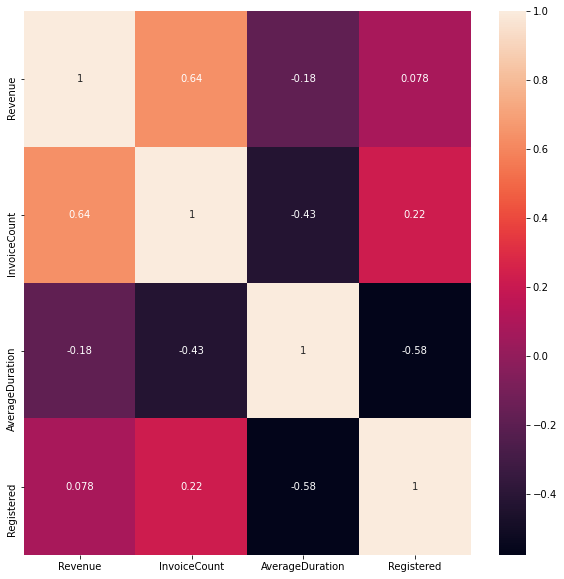

In [11]:
plt.figure(figsize=(10,10))
sns.heatmap(scv[features].corr(),annot=True)
plt.show()

### KMeans

In [12]:
## Inputs
X = scv[features]
X

Revenue  InvoiceCount  AverageDuration  Registered
0      169.36             2            118.0           1
1     1323.32             2             37.0           1
2      221.16             1            365.0           1
3     2221.14             2            182.0           1
4      300.93             1            365.0           1
...       ...           ...              ...         ...
5936     7.50             1            365.0           0
5937  1667.95             1            365.0           0
5938  1825.48             1            365.0           0
5939  2268.88             1            365.0           0
5940   208.22             1            365.0           0

[5941 rows x 4 columns]

In [13]:
## Standardise
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
## I'm going to use the Silhouette score and Elbow method to select the optimum number of clusters

means_scores = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=124)
    kmeans.fit(X_scaled)
    means_scores.append(metrics.silhouette_score(X_scaled, kmeans.labels_))

means_inertia = []

for i in range(1,10):
    kmeans = KMeans(i, random_state=124)
    kmeans.fit(X_scaled)
    means_inertia.append(kmeans.inertia_)

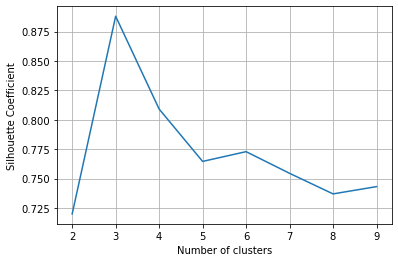

In [15]:
plt.plot(range(2, 10), means_scores)

plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

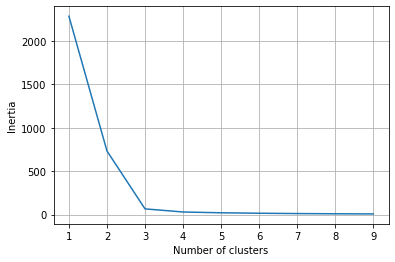

In [16]:
plt.plot(range(1,10), means_inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)

In [17]:
## Model
km = KMeans(n_clusters=3, random_state=124)
km.fit(X_scaled)

KMeans(n_clusters=3, random_state=124)

In [18]:
scv['cluster'] = km.labels_

In [19]:
## Evaluation
metrics.silhouette_score(X_scaled, scv['cluster'])

0.8880189280373201

In [20]:
scv.cluster.value_counts()

0    2741
1    1656
2    1544
Name: cluster, dtype: int64

In [21]:
scv.groupby('cluster').mean()

InvoiceCount      Revenue  AverageMonthlyRevenue  AverageDuration  \
cluster                                                                      
0            6.308282  2937.503152             244.791929        56.918643   
1            1.000000   703.496395              58.624700       365.000000   
2            1.084845   380.803795              31.733650       356.820596   

            Recency  Registered  
cluster                          
0         60.896753         1.0  
1        178.407609         0.0  
2        140.413860         1.0

In [22]:
scv.groupby('cluster').sum()

InvoiceCount     Revenue  AverageMonthlyRevenue  AverageDuration  \
cluster                                                                     
0               17291  8051696.14          670974.678333         156014.0   
1                1656  1164990.03           97082.502500         604440.0   
2                1675   587961.06           48996.755000         550931.0   

         Recency  Registered  
cluster                       
0         166918        2741  
1         295443           0  
2         216799        1544

In [23]:
scv.Revenue.sum()

9804647.229999999

In [24]:
a = 9804647.23
print(round((8051696.14/a)*100, 2), round((1164990.03/a)*100, 2), round((587961.06/a)*100, 2))

82.12 11.88 6.0


In [25]:
scv[scv.cluster==1].Registered.value_counts()

0    1656
Name: Registered, dtype: int64

/Users/ikram/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/ikram/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/ikram/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/ikram/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/ikram/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


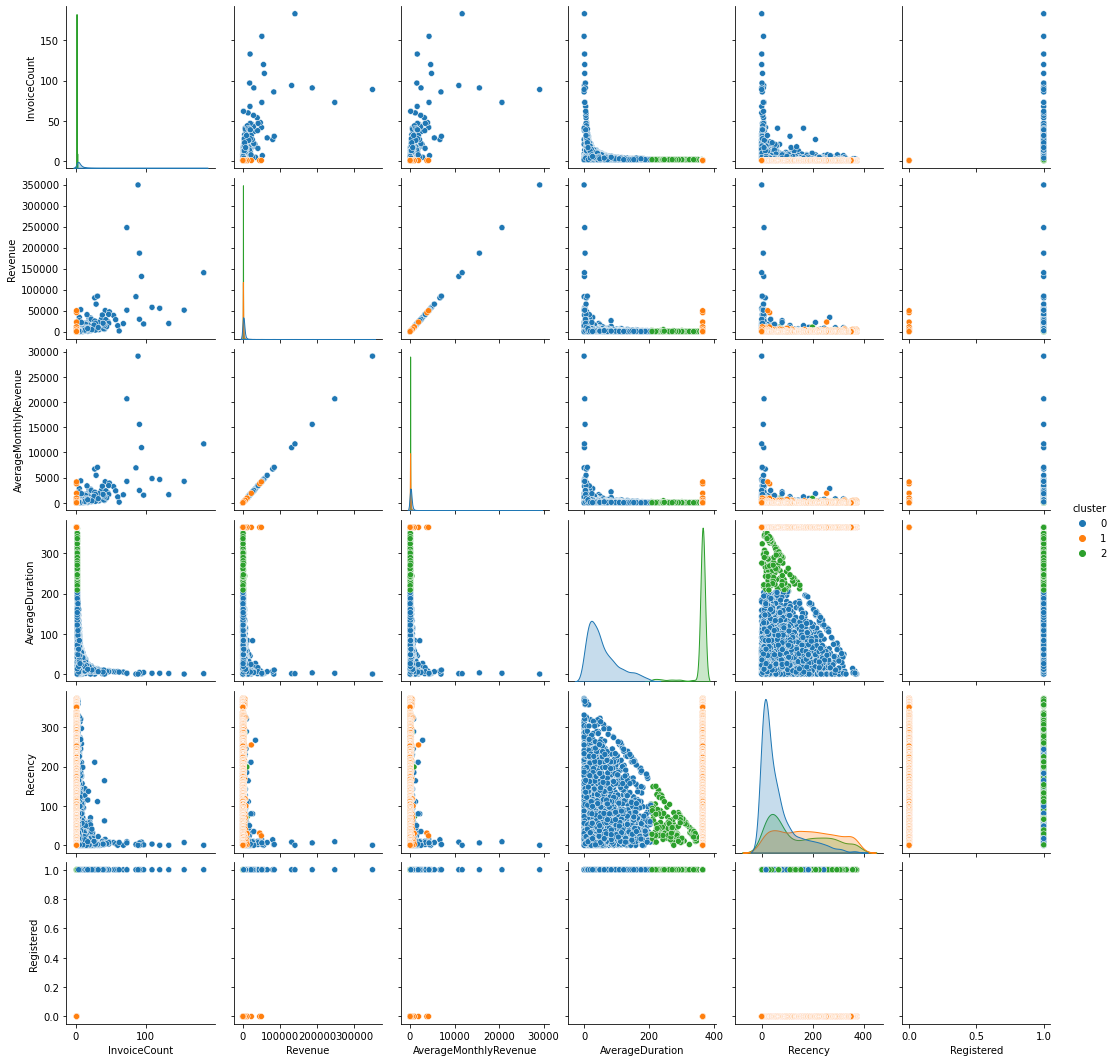

In [26]:
sns.pairplot(scv[['InvoiceCount', 'Revenue', 'AverageMonthlyRevenue',
       'AverageDuration', 'Recency', 'Registered',
       'cluster']], hue='cluster', palette='tab10')

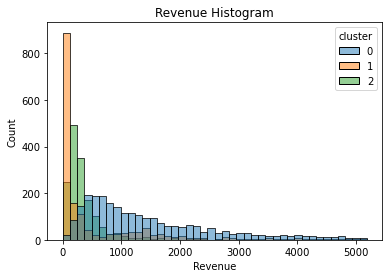

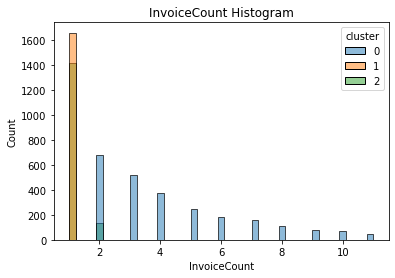

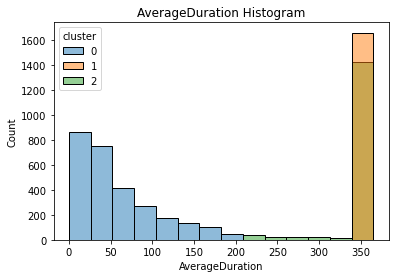

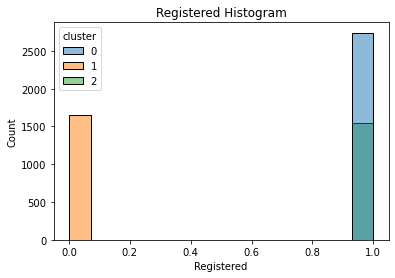

In [27]:
## Histograms with clusters

for i in features:
    sns.histplot(data = scv[scv[i]<=scv[i].quantile(0.95)], x=i, hue='cluster', palette='tab10')
    plt.title(f'{i} Histogram')
    plt.show()

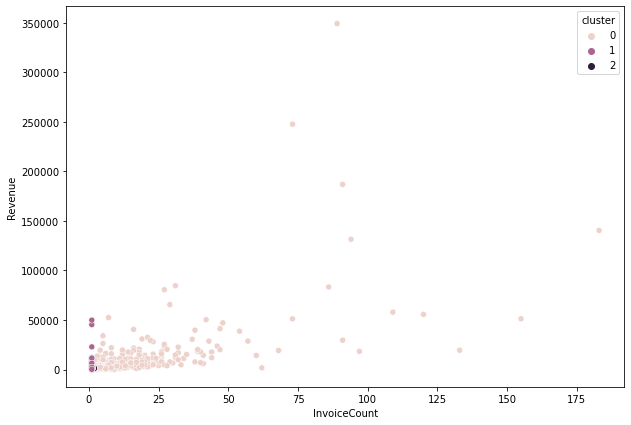

In [28]:
plt.figure(figsize=(10,7))
sns.scatterplot(data=scv, x='InvoiceCount', y='Revenue', hue='cluster')
plt.show()

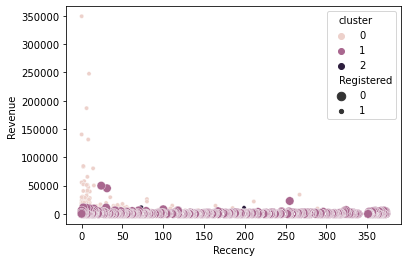

In [29]:
sns.scatterplot(data=scv, x='Recency', y='Revenue', hue='cluster', size='Registered')
plt.show()

### KMediods
kmeans is sensitive to outliers

In [30]:
##pip install scikit-learn-extra

In [31]:
## I'm going to use the Silhouette score and Elbow method to select the optimum number of clusters

mediods_scores = []
mediods_inertia = []

for k in range(2, 10):
    kmedoids = KMedoids(n_clusters=k, random_state=0)
    kmedoids.fit(X_scaled)
    mediods_scores.append(metrics.silhouette_score(X_scaled, kmedoids.labels_))
    mediods_inertia.append(kmedoids.inertia_)

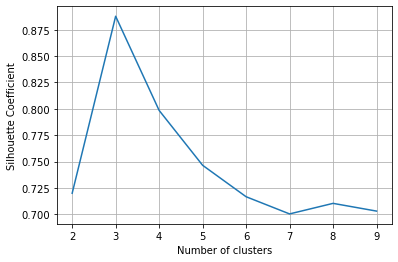

In [32]:
plt.plot(range(2, 10), mediods_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

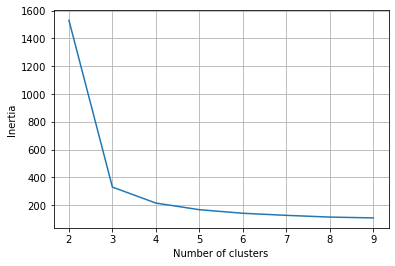

In [33]:
plt.plot(range(2,10), mediods_inertia)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)

In [34]:
## Model
kmd = KMedoids(n_clusters=3, random_state=0)
kmd.fit(X_scaled)

KMedoids(n_clusters=3, random_state=0)

In [35]:
scv['cluster_2'] = kmd.labels_
scv.cluster_2.value_counts()

0    2738
1    1656
2    1547
Name: cluster_2, dtype: int64

### Comparing KMeans and KMediods

In [36]:
scv.groupby('cluster_2').mean()

InvoiceCount      Revenue  AverageMonthlyRevenue  AverageDuration  \
cluster_2                                                                      
0              6.313002  2940.062513             245.005209        56.756026   
1              1.000000   703.496395              58.624700       365.000000   
2              1.086619   381.232088              31.769341       356.526826   

              Recency  Registered   cluster  
cluster_2                                    
0           60.866691         1.0  0.000000  
1          178.407609         0.0  1.000000  
2          140.312864         1.0  1.996122

In [37]:
scv.groupby('cluster').mean()

InvoiceCount      Revenue  AverageMonthlyRevenue  AverageDuration  \
cluster                                                                      
0            6.308282  2937.503152             244.791929        56.918643   
1            1.000000   703.496395              58.624700       365.000000   
2            1.084845   380.803795              31.733650       356.820596   

            Recency  Registered  cluster_2  
cluster                                     
0         60.896753         1.0   0.002189  
1        178.407609         0.0   1.000000  
2        140.413860         1.0   2.000000

In [38]:
print(metrics.silhouette_score(X_scaled, scv['cluster']))
print(metrics.silhouette_score(X_scaled, scv['cluster_2']))

0.8880189280373201
0.8878406450459031


#### There is no significant difference between KMeans and KMediods so I'm going to use the KMeans clusters.

### Plotting the clusters

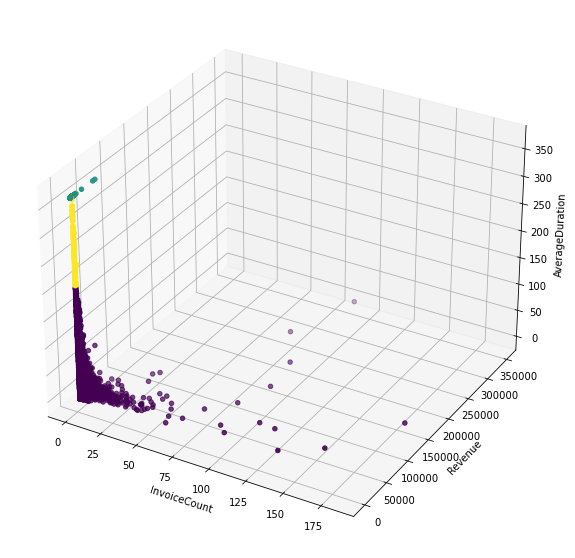

In [39]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
mpl.rcParams['legend.fontsize'] = 10
x = scv['InvoiceCount']
y = scv['Revenue']
z = scv['AverageDuration']

ax.scatter(x, y, z, c=scv['cluster'], label=scv['cluster'])

ax.set_xlabel('InvoiceCount')
ax.set_ylabel('Revenue')
ax.set_zlabel('AverageDuration')

plt.show()

In [40]:
## To get a clean and closer view of the clusters
p_scv = scv[['Revenue', 'InvoiceCount', 'AverageDuration', 'Registered', 'cluster']].copy()
p_scv = p_scv[p_scv.Revenue<=40000]
p_scv = p_scv[p_scv.InvoiceCount<=30]
p_scv 

Revenue  InvoiceCount  AverageDuration  Registered  cluster
0      169.36             2            118.0           1        0
1     1323.32             2             37.0           1        0
2      221.16             1            365.0           1        2
3     2221.14             2            182.0           1        0
4      300.93             1            365.0           1        2
...       ...           ...              ...         ...      ...
5936     7.50             1            365.0           0        1
5937  1667.95             1            365.0           0        1
5938  1825.48             1            365.0           0        1
5939  2268.88             1            365.0           0        1
5940   208.22             1            365.0           0        1

[5889 rows x 5 columns]

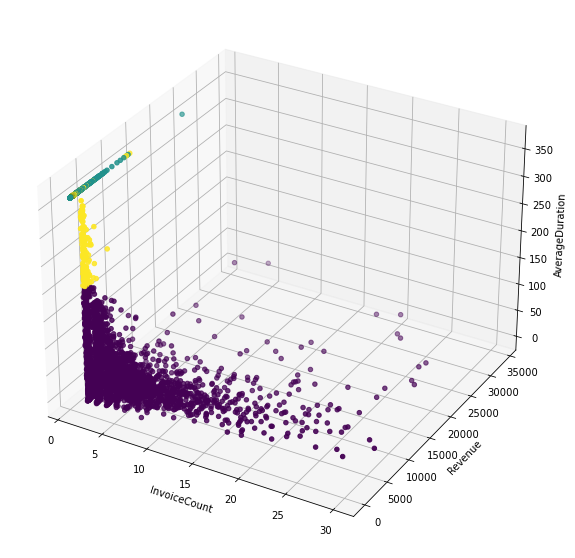

In [41]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
mpl.rcParams['legend.fontsize'] = 10
x = p_scv['InvoiceCount']
y = p_scv['Revenue']
z = p_scv['AverageDuration']

ax.scatter(x, y, z, c=p_scv['cluster'], label=p_scv['cluster'])

ax.set_xlabel('InvoiceCount')
ax.set_ylabel('Revenue')
ax.set_zlabel('AverageDuration')

plt.show()

In [42]:
## pip install plotly==3.0.0

In [43]:
## conda install -c plotly plotly_express

In [44]:

x = "InvoiceCount"
y = "Revenue"
z = "AverageDuration"
scv["cluster"] = scv["cluster"].astype(str)
fig = px.scatter_3d(scv, x="InvoiceCount", y="Revenue", z="AverageDuration",
                    color="cluster",
                   labels = {
                       "x":"InvoiceCount",
                       "y":"Revenue",
                       "z":"AverageDuration"
                   },
                   )

fig.show()

## Timeseries

I want to look at the 12 month period from December 2009.

In [45]:
ts = orders.groupby('Date')[['Amount']].sum()
ts['InvoiceCount'] = orders.groupby('Date')['Invoice'].count()
ts.rename(columns={'Amount':'Revenue'}, inplace=True)
ts = ts[ts.index.date<datetime.date(2010,12,1)]
ts

Revenue  InvoiceCount
Date                              
2009-12-01  52438.61           117
2009-12-02  61873.10           115
2009-12-03  73059.78           124
2009-12-04  39349.21            88
2009-12-05   9803.05            30
...              ...           ...
2010-11-25  71385.94           151
2010-11-26  39002.80            88
2010-11-28  26688.66            90
2010-11-29  77058.57           106
2010-11-30  59400.54           122

[299 rows x 2 columns]

In [46]:
## Fill in the missing days
ts = ts.resample('D').sum()
ts

Revenue  InvoiceCount
Date                              
2009-12-01  52438.61           117
2009-12-02  61873.10           115
2009-12-03  73059.78           124
2009-12-04  39349.21            88
2009-12-05   9803.05            30
...              ...           ...
2010-11-26  39002.80            88
2010-11-27      0.00             0
2010-11-28  26688.66            90
2010-11-29  77058.57           106
2010-11-30  59400.54           122

[365 rows x 2 columns]

In [47]:
ts.diff()

Revenue  InvoiceCount
Date                              
2009-12-01       NaN           NaN
2009-12-02   9434.49          -2.0
2009-12-03  11186.68           9.0
2009-12-04 -33710.57         -36.0
2009-12-05 -29546.16         -58.0
...              ...           ...
2010-11-26 -32383.14         -63.0
2010-11-27 -39002.80         -88.0
2010-11-28  26688.66          90.0
2010-11-29  50369.91          16.0
2010-11-30 -17658.03          16.0

[365 rows x 2 columns]

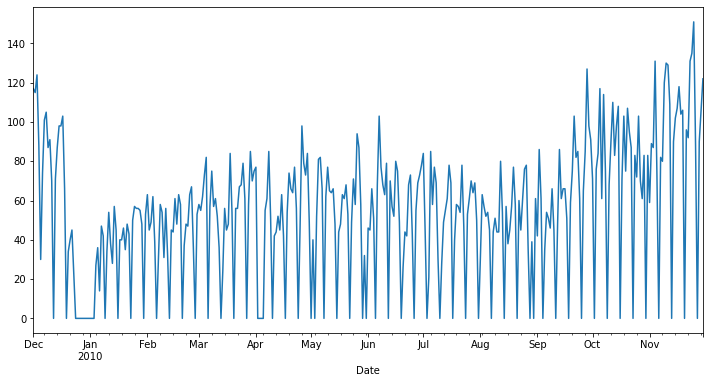

In [48]:
plt.figure(figsize=(12,6))
ts.InvoiceCount.plot()
plt.show()

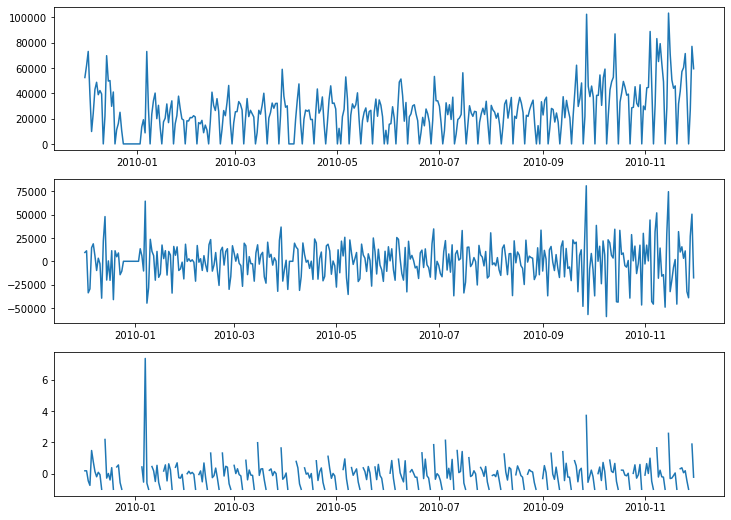

In [49]:
fig, axes = plt.subplots(nrows=3, figsize=(12,9))

axes[0].plot(ts.Revenue)
axes[1].plot(ts.Revenue.diff())
axes[2].plot(ts.Revenue.pct_change())
plt.show()

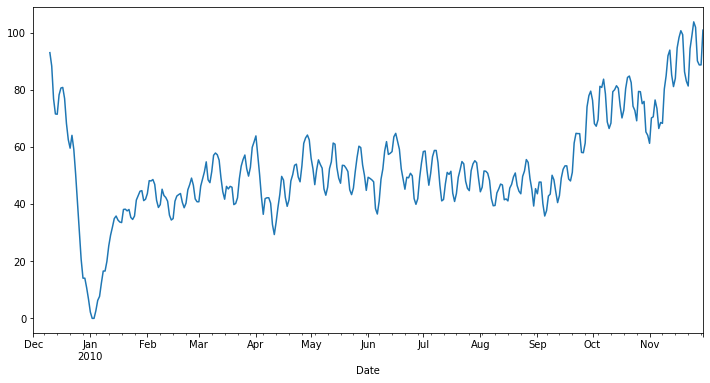

In [50]:
plt.figure(figsize=(12,6))
ts.InvoiceCount.rolling(10).mean().plot()
plt.show()

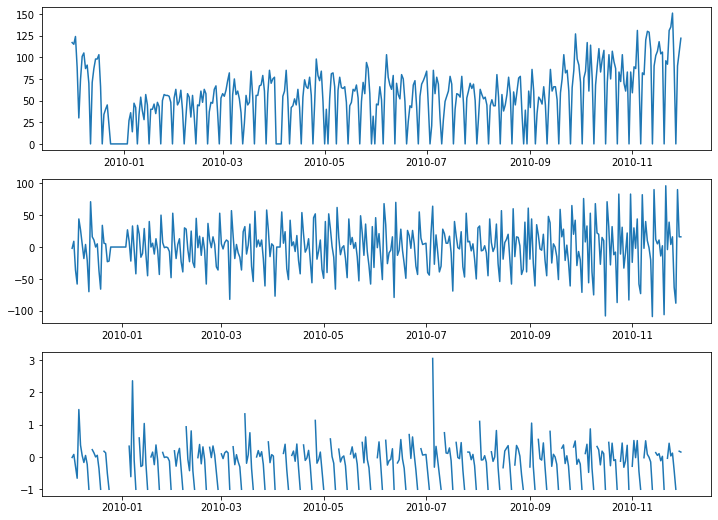

In [51]:
fig, axes = plt.subplots(nrows=3, figsize=(12,9))

axes[0].plot(ts.InvoiceCount)
axes[1].plot(ts.InvoiceCount.diff())
axes[2].plot(ts.InvoiceCount.pct_change())
plt.show()

<AxesSubplot:xlabel='InvoiceCount', ylabel='Revenue'>

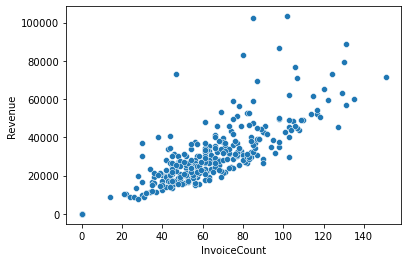

In [52]:
sns.scatterplot(x=ts['InvoiceCount'], y = ts['Revenue'])

<AxesSubplot:>

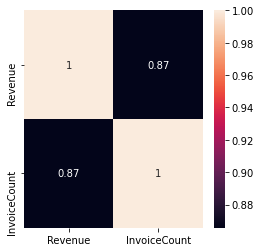

In [53]:
plt.figure(figsize=(4,4))
sns.heatmap(ts.corr(), annot=True)

In [54]:
## Revenue has a high correlation with InvoiceCount so I'm going to drop it.
ts.drop('Revenue', axis=1, inplace=True)

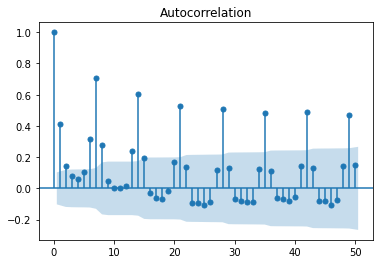

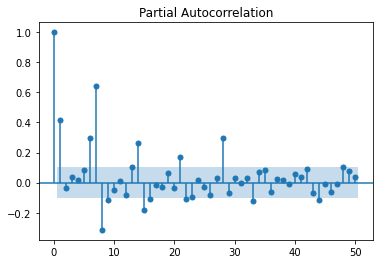

In [55]:
plot_acf(ts.InvoiceCount, lags = 50);
plot_pacf(ts.InvoiceCount, lags = 50);

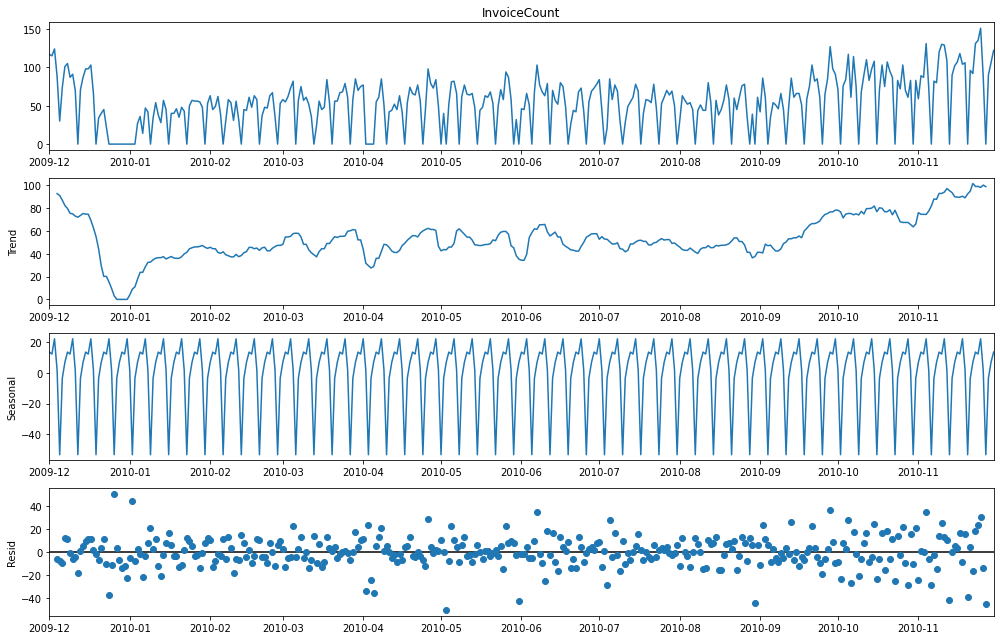

In [56]:
decomp = seasonal_decompose(ts.InvoiceCount, model='additive')
plt.rcParams['figure.figsize'] = (14, 9)
decomp.plot();

### SARIMAX

- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period.


- SARIMA(p,d,q)(P,D,Q)m

q and Q are both 0 due to no significant negative spikes in the acf and pacf
p and P are both
s maybe 7 there are significant positive spikes at lags 7, 14 

In [57]:
## from observing the pacf and acf plots (1, 1, 0),( 1, 1, 0, 7)
my_order = (1, 1, 0)
my_seasonal_order = ( 1, 1, 0, 7)
sari1 = SARIMAX(ts[['InvoiceCount']], order=my_order, seasonal_order=my_seasonal_order, trend='n').fit()
sari1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                      InvoiceCount   No. Observations:                  365
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 7)   Log Likelihood               -1581.383
Date:                           Wed, 30 Jun 2021   AIC                           3168.766
Time:                                   17:05:31   BIC                           3180.400
Sample:                               12-01-2009   HQIC                          3173.393
                                    - 11-30-2010                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4321      0.040    -10.686      0.000      -0.511      -0.353
ar.S.L7       -0.4798      0.041    -11.778      0.000      -0.560      -0.400
sigma2       409.8189     24.698     16.593      0.000     361.412     458.226
===================================================================================
Ljung-Box (L1) (Q):                   2.79   Jarque-Bera (JB):                24.23
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                             0.16
Prob(H) (two-sided):                  0.53   Kurtosis:                         4.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [58]:
sari1.aic

3168.7663141102803

In [59]:
sari1_predictions = sari1.predict()
sari1_predictions

Date
2009-12-01      0.000000
2009-12-02    116.983319
2009-12-03    115.007998
2009-12-04    123.993453
2009-12-05     88.014346
                 ...    
2010-11-26    132.177611
2010-11-27      4.083880
2010-11-28     84.722252
2010-11-29     95.025287
2010-11-30    123.362560
Freq: D, Name: predicted_mean, Length: 365, dtype: float64

In [60]:
metrics.r2_score(ts.values, sari1_predictions)

0.5792054934513208

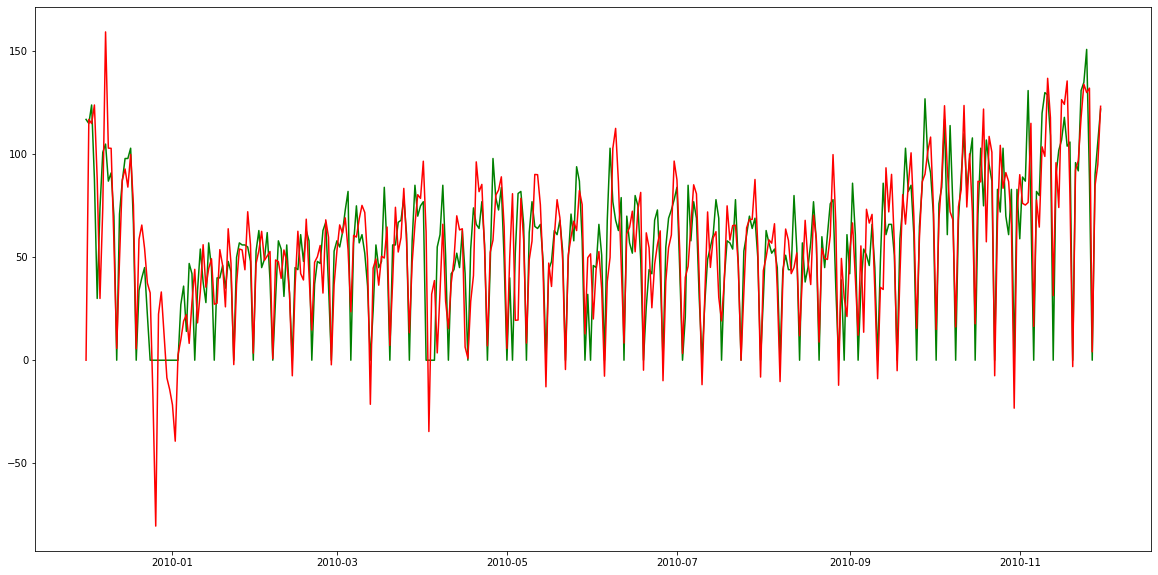

In [61]:
plt.figure(figsize=(20,10))
plt.plot(ts.index, ts.values, color='green')
plt.plot(sari1_predictions, color='red')
plt.show()

### Gridsearch

In [62]:
import itertools
#set parameter range
p = range(0,3)
q = range(1,3)
d = range(1,2)
s = range(7,12)
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q, s))
aic_list = []
i = 0
# SARIMA model pipeline
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(ts[['InvoiceCount']],
                                    order=param,
                                    seasonal_order=param_seasonal)
            results = mod.fit(max_iter = 50, method = 'powell')
            aic_list.append(results.aic)
            i+=1
            print(i,' SARIMAX{},{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Optimization terminated successfully.
         Current function value: 4.172262
         Iterations: 3
         Function evaluations: 116
1  SARIMAX(0, 1, 1),(0, 1, 1, 7) - AIC:3051.751525311371
Optimization terminated successfully.
         Current function value: 4.768670
         Iterations: 3
         Function evaluations: 113
2  SARIMAX(0, 1, 1),(0, 1, 1, 8) - AIC:3487.1292677426045
Optimization terminated successfully.
         Current function value: 4.762523
         Iterations: 3
         Function evaluations: 119
3  SARIMAX(0, 1, 1),(0, 1, 1, 9) - AIC:3482.6417163253873
Optimization terminated successfully.
         Current function value: 4.748336
         Iterations: 3
         Function evaluations: 119
4  SARIMAX(0, 1, 1),(0, 1, 1, 10) - AIC:3472.28497593911
Optimization terminated successfully.
         Current function value: 4.745897
         Iterations: 3
         Function evaluations: 121
5  SARIMAX(0, 1, 1),(0, 1, 1, 11) - AIC:3470.50465913136
Optimization terminated

/Users/ikram/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:977: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 4.726219
         Iterations: 3
         Function evaluations: 154
33  SARIMAX(0, 1, 2),(0, 1, 1, 9) - AIC:3458.1395219068727
Optimization terminated successfully.
         Current function value: 4.713778
         Iterations: 3
         Function evaluations: 151
34  SARIMAX(0, 1, 2),(0, 1, 1, 10) - AIC:3449.0581428898386
Optimization terminated successfully.
         Current function value: 4.709486
         Iterations: 3
         Function evaluations: 159
35  SARIMAX(0, 1, 2),(0, 1, 1, 11) - AIC:3445.9248355035224
Optimization terminated successfully.
         Current function value: 4.167156
         Iterations: 3
         Function evaluations: 172
36  SARIMAX(0, 1, 2),(0, 1, 2, 7) - AIC:3052.0238379977122
Optimization terminated successfully.
         Current function value: 4.731393
         Iterations: 3
         Function evaluations: 190
37  SARIMAX(0, 1, 2),(0, 1, 2, 8) - AIC:3463.9169456206914
Optimization 

Optimization terminated successfully.
         Current function value: 4.710232
         Iterations: 5
         Function evaluations: 317
75  SARIMAX(1, 1, 1),(1, 1, 1, 11) - AIC:3448.469512258029
Optimization terminated successfully.
         Current function value: 4.164690
         Iterations: 4
         Function evaluations: 289
76  SARIMAX(1, 1, 1),(1, 1, 2, 7) - AIC:3052.2234409222165
Optimization terminated successfully.
         Current function value: 4.734464
         Iterations: 3
         Function evaluations: 226
77  SARIMAX(1, 1, 1),(1, 1, 2, 8) - AIC:3468.1587464143226
Optimization terminated successfully.
         Current function value: 4.719808
         Iterations: 6
         Function evaluations: 439
78  SARIMAX(1, 1, 1),(1, 1, 2, 9) - AIC:3457.459721866135
Optimization terminated successfully.
         Current function value: 4.713238
         Iterations: 4
         Function evaluations: 356
79  SARIMAX(1, 1, 1),(1, 1, 2, 10) - AIC:3452.6634432341148
Optimization te

/Users/ikram/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 4.731252
         Iterations: 3
         Function evaluations: 187
92  SARIMAX(1, 1, 2),(0, 1, 1, 8) - AIC:3463.8140850099
Optimization terminated successfully.
         Current function value: 4.714380
         Iterations: 6
         Function evaluations: 420
93  SARIMAX(1, 1, 2),(0, 1, 1, 9) - AIC:3451.4976213338205
Optimization terminated successfully.
         Current function value: 4.712995
         Iterations: 3
         Function evaluations: 190
94  SARIMAX(1, 1, 2),(0, 1, 1, 10) - AIC:3450.48659935526
Optimization terminated successfully.
         Current function value: 4.709182
         Iterations: 3
         Function evaluations: 189
95  SARIMAX(1, 1, 2),(0, 1, 1, 11) - AIC:3447.7031949192815
Optimization terminated successfully.
         Current function value: 4.168325
         Iterations: 3
         Function evaluations: 206
96  SARIMAX(1, 1, 2),(0, 1, 2, 7) - AIC:3054.8769337952103
Optimization termi

Optimization terminated successfully.
         Current function value: 4.695322
         Iterations: 6
         Function evaluations: 506
134  SARIMAX(2, 1, 1),(1, 1, 1, 10) - AIC:3439.5853813701056
Optimization terminated successfully.
         Current function value: 4.695597
         Iterations: 6
         Function evaluations: 451
135  SARIMAX(2, 1, 1),(1, 1, 1, 11) - AIC:3439.785962734819
Optimization terminated successfully.
         Current function value: 4.158748
         Iterations: 8
         Function evaluations: 684
136  SARIMAX(2, 1, 1),(1, 1, 2, 7) - AIC:3049.885948231983
Optimization terminated successfully.
         Current function value: 4.725779
         Iterations: 4
         Function evaluations: 339
137  SARIMAX(2, 1, 1),(1, 1, 2, 8) - AIC:3463.8187275012615
Optimization terminated successfully.
         Current function value: 4.707993
         Iterations: 6
         Function evaluations: 499
138  SARIMAX(2, 1, 1),(1, 1, 2, 9) - AIC:3450.8352492535787
Optimizati

Optimization terminated successfully.
         Current function value: 4.162337
         Iterations: 5
         Function evaluations: 523
176  SARIMAX(2, 1, 2),(2, 1, 2, 7) - AIC:3056.5062608466396
Optimization terminated successfully.
         Current function value: 4.705428
         Iterations: 8
         Function evaluations: 903
177  SARIMAX(2, 1, 2),(2, 1, 2, 8) - AIC:3452.9623826472734
Optimization terminated successfully.
         Current function value: 4.683758
         Iterations: 6
         Function evaluations: 690
178  SARIMAX(2, 1, 2),(2, 1, 2, 9) - AIC:3437.1434131355513
Optimization terminated successfully.
         Current function value: 4.695123
         Iterations: 6
         Function evaluations: 656
179  SARIMAX(2, 1, 2),(2, 1, 2, 10) - AIC:3445.4401087839683
Optimization terminated successfully.
         Current function value: 4.697118
         Iterations: 6
         Function evaluations: 653
180  SARIMAX(2, 1, 2),(2, 1, 2, 11) - AIC:3446.895833498509


In [63]:
min(aic_list)

3045.932602895523

In [64]:
aic_list.index(min(aic_list))

120

121  SARIMA(2, 1, 1),(0, 1, 1, 7) - AIC:3045.932602895523

In [65]:
## Inputs
y = ts[['InvoiceCount']]

In [66]:
## Train Test Split
x1, x2, train, test = train_test_split(y,y, test_size= 0.2, shuffle = False)

In [67]:
## Model
my_order = (2, 1, 1)
my_seasonal_order = (0, 1, 1, 7)
sari2 = SARIMAX(train, order=my_order, seasonal_order=my_seasonal_order, trend='n').fit()
sari2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                      InvoiceCount   No. Observations:                  292
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -1199.438
Date:                           Wed, 30 Jun 2021   AIC                           2408.876
Time:                                   17:10:59   BIC                           2427.121
Sample:                               12-01-2009   HQIC                          2416.190
                                    - 09-18-2010                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8647      0.205     -4.220      0.000      -1.266      -0.463
ar.L2         -0.3467      0.073     -4.728      0.000      -0.490      -0.203
ma.L1          0.4448      0.222      2.005      0.045       0.010       0.880
ma.S.L7       -0.9935      0.239     -4.160      0.000      -1.461      -0.525
sigma2       250.2783     56.919      4.397      0.000     138.719     361.837
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                68.16
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                             0.15
Prob(H) (two-sided):                  0.73   Kurtosis:                         5.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [68]:
sari2_predictions = sari2.predict()
sari2_predictions

Date
2009-12-01      0.000000
2009-12-02    116.986779
2009-12-03    114.998691
2009-12-04    124.005492
2009-12-05     88.000625
                 ...    
2010-09-14     77.088002
2010-09-15     69.603575
2010-09-16     81.129256
2010-09-17     45.869190
2010-09-18      4.023730
Freq: D, Name: predicted_mean, Length: 292, dtype: float64

In [69]:
metrics.r2_score(train, sari2_predictions)

0.5676502077143795

In [70]:
sari2.forecast(3)

2010-09-19    41.175074
2010-09-20    54.537676
2010-09-21    55.621494
Freq: D, Name: predicted_mean, dtype: float64

In [71]:
y_hat = sari2.apply(test.values)
y_hat.fittedvalues

array([  0.        ,  58.99333293,  74.9954969 , 102.99695719,
        82.00242249,  85.00280679,  61.00317444,  29.51257679,
        80.98741675, 111.50190717,  98.87103017, 102.68894991,
        73.45938111,   8.10030268,  69.82477179,  92.42997804,
       121.40151625,  95.2858155 ,  71.15396558,  74.75129707,
         4.20623682,  82.2848088 ,  81.96135018, 122.70869953,
        78.8825133 ,  98.88373997,  68.37871212,  24.27006961,
        79.8477048 ,  95.80943822, 123.37764622,  65.71449302,
       105.39557884,  73.54762063,  15.1961956 ,  67.04600615,
       101.49202456,  99.92553531,  84.41878025,  80.89647586,
        57.09463585, -12.0111825 ,  66.79581881,  96.41380144,
        92.93583853,  70.54346571,  80.71778935, 104.6495312 ,
         7.15149176,  80.54336753,  81.92170485, 108.06541055,
        94.42667593, 126.58926553, 114.78294982,  34.38056872,
        86.11025341,  96.40567186, 119.98030102, 100.88267957,
       119.94368658,  91.8920959 ,  21.1335448 ,  80.36

In [72]:
metrics.r2_score(test.values,y_hat.fittedvalues)

0.6391491536737783

In [73]:
pow(metrics.mean_squared_error(test.values,y_hat.fittedvalues),0.5)

22.72582715768117

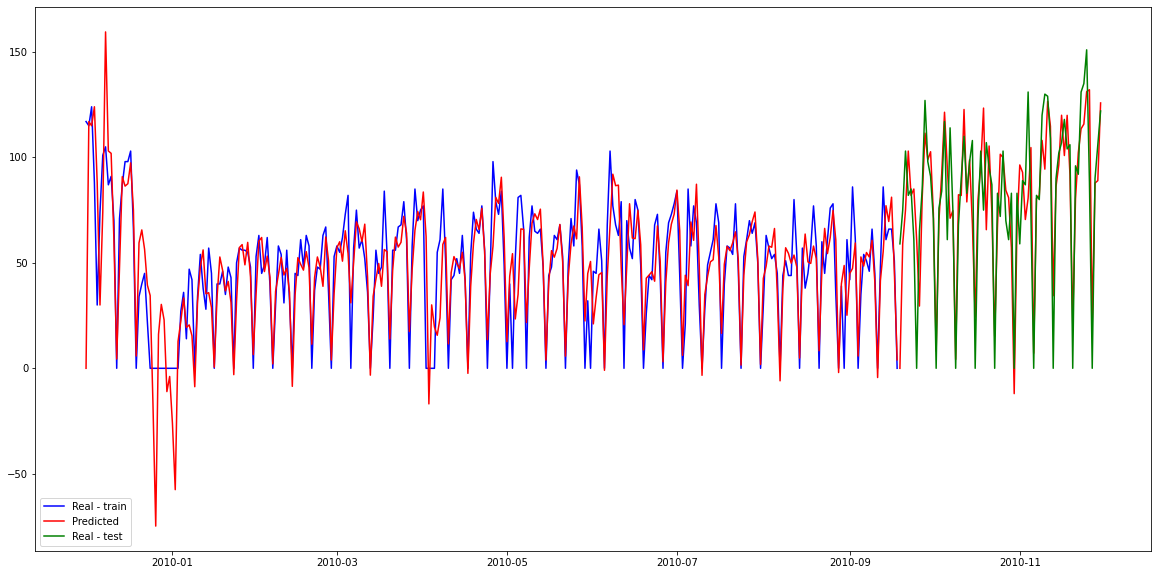

In [74]:
plt.figure(figsize=(20,10))
plt.plot(train.index, train.values, color='blue', label = 'Real - train')
plt.plot(test.index, y_hat.fittedvalues, color='red', label = 'Predicted')
plt.plot(test.index, test.values, color='green', label = 'Real - test')
plt.plot(sari2_predictions, color='red')
plt.legend()
plt.savefig('timeseries plot.png')
plt.show()